In [1]:
import os 
import math
import requests

import pandas as pd 
import numpy as np 
import seaborn as sns
from collections import defaultdict
from string import punctuation
from parsivar import Tokenizer, Normalizer, FindStems


from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, recall_score

In [2]:
LABELS = {
    "اجتماعی" : "social",
    "اديان" : "religion",
    "اقتصادی" : "economics",
    "سیاسی" : "politics",
    "فناوري" : "technology" ,
    "مسائل راهبردي ايران" : "strategic" ,
    "ورزشی" : "sport",
}

In [3]:
persian = requests.get('https://raw.githubusercontent.com/kharazi/persian-stopwords/master/persian').text.split('\n')
verbal = requests.get('https://raw.githubusercontent.com/kharazi/persian-stopwords/master/verbal').text.split('\n')
nonverbal = requests.get('https://raw.githubusercontent.com/kharazi/persian-stopwords/master/nonverbal').text.split('\n')

stop_words = persian + verbal + nonverbal

In [4]:
train_texts = []
train_labels = []

test_texts = []
test_labels = []

def extract_texts (root, label , file, is_train) :
    path = root + '/' + file 
    with open(path,'r',encoding="utf-8") as f : 
        text = f.read()
        
        if is_train :
            train_texts.append(text)
            train_labels.append(LABELS[label])
        else :
            test_texts.append(text)
            test_labels.append(LABELS[label])

In [5]:
for (root,dirs,files) in os.walk('./Final_Dataset/Train') :
    
    if len(files) == 0 :
        continue
    for f in files :
        label = root.split('\\')[1]
        extract_texts(root,label,f, True)
    

In [6]:
train = pd.DataFrame()
train['text'] = train_texts 
train['label'] = train_labels

In [7]:
for (root,dirs,files) in os.walk('./Final_Dataset/Test') :
    
    if len(files) == 0 :
        continue
    for f in files :
        label = root.split('\\')[1]
        
        extract_texts(root,label,f, False)
    

In [8]:
test = pd.DataFrame()
test['text'] = test_texts 
test['label'] = test_labels

In [10]:
my_punctuation = punctuation + '،"؛«»)\('

In [11]:
tokenizer = Tokenizer()
normalizer = Normalizer()
stemmer = FindStems()

In [12]:
def normalize_text (text) :
    
    tokens = tokenizer.tokenize_words(normalizer.normalize(text))
    text = ' '.join([word for word in tokens if word not in list(my_punctuation)])
    text = text.replace("nbsp", " ")
    text = text.replace("amp", " ")
    text = text.replace("ي", "ی" )
    text = text.replace('ك', 'ک')
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    
#     if remove_stop_words :
#         tokens = [stemmer.convert_to_stem(word).split('&')[0] for word in tokens if word not in stop_words]
    return text

# Text classification without IDF

In [44]:
vectorizer = TfidfVectorizer(max_features=500, preprocessor=normalize_text, use_idf=False).fit(pd.concat([train,test]).text)

In [45]:
train_vectors = vectorizer.transform(train.text)

In [46]:
test_vectors = vectorizer.transform(test.text)

In [47]:
x_train,x_test , y_train,y_test = train_test_split(train_vectors, train.label, \
                                                  random_state=101, stratify=train.label)

In [48]:
ks = [1,3,5,15]
for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k ,weights='distance',)
    knn_model.fit(x_train,y_train)
    y_pred = knn_model.predict(x_test)
    print(f'K = {k}')
    print(f'accuracy = {accuracy_score(y_test,y_pred)}')
    
    print('----------')

K = 1
accuracy = 0.42857142857142855
----------
K = 3
accuracy = 0.5714285714285714
----------
K = 5
accuracy = 0.5714285714285714
----------
K = 15
accuracy = 0.5714285714285714
----------


### Apply KNN with n_neighbors = 5 to test dataset 

K = 5
accuracy = 0.8571428571428571


<AxesSubplot:>

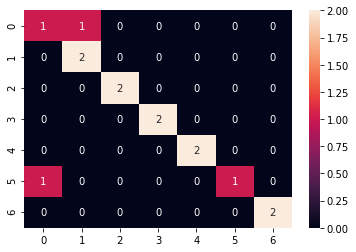

In [49]:
knn_model = KNeighborsClassifier(n_neighbors=5 ,weights='distance',)
knn_model.fit(train_vectors,train.label)
y_pred = knn_model.predict(test_vectors)
print('K = 5')
print(f'accuracy = {accuracy_score(test.label,y_pred)}')
sns.heatmap(confusion_matrix(test.label,y_pred), annot=True)


# Text classfication with IDF

In [50]:
vectorizer = TfidfVectorizer(max_features=500, preprocessor=normalize_text).fit(pd.concat([train,test]).text)

In [51]:
train_vectors = vectorizer.transform(train.text)

In [52]:
test_vectors = vectorizer.transform(test.text)

In [53]:
x_train,x_test , y_train,y_test = train_test_split(train_vectors, train.label, \
                                                  random_state=101, stratify=train.label)

In [54]:
ks = [1,3,5,15]
for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k ,weights='distance',)
    knn_model.fit(x_train,y_train)
    y_pred = knn_model.predict(x_test)
    print(f'K = {k}')
    print(f'accuracy = {accuracy_score(y_test,y_pred)}')
    
    print('----------')

K = 1
accuracy = 0.6428571428571429
----------
K = 3
accuracy = 0.6428571428571429
----------
K = 5
accuracy = 0.6428571428571429
----------
K = 15
accuracy = 0.6428571428571429
----------


### Apply KNN with n_neighbors = 5 to test dataset 

K = 5
accuracy = 0.7857142857142857


<AxesSubplot:>

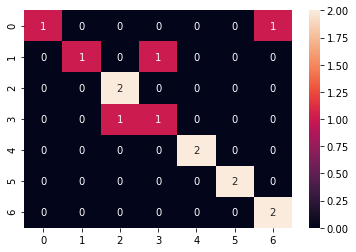

In [55]:
knn_model = KNeighborsClassifier(n_neighbors=5 ,weights='distance',)
knn_model.fit(train_vectors,train.label)
y_pred = knn_model.predict(test_vectors)
print('K = 5')
print(f'accuracy = {accuracy_score(test.label,y_pred)}')
sns.heatmap(confusion_matrix(test.label,y_pred), annot=True)


# Text classificatin with removing stop words and using IDF

In [58]:
def normalize_text (text) :
    
    tokens = tokenizer.tokenize_words(normalizer.normalize(text))
    tokens = [stemmer.convert_to_stem(word).split('&')[0] for word in tokens if word not in stop_words]
    text = ' '.join([word for word in tokens if word not in list(my_punctuation)])
    text = text.replace("nbsp", " ")
    text = text.replace("amp", " ")
    text = text.replace("ي", "ی" )
    text = text.replace('ك', 'ک')
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    
    return text

In [59]:
vectorizer = TfidfVectorizer(max_features=500, preprocessor=normalize_text).fit(pd.concat([train,test]).text)

In [60]:
train_vectors = vectorizer.transform(train.text)

In [61]:
test_vectors = vectorizer.transform(test.text)

In [62]:
x_train,x_test , y_train,y_test = train_test_split(train_vectors, train.label, \
                                                  random_state=101, stratify=train.label)

In [63]:
ks = [1,3,5,15]
for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k ,weights='distance',)
    knn_model.fit(x_train,y_train)
    y_pred = knn_model.predict(x_test)
    print(f'K = {k}')
    print(f'accuracy = {accuracy_score(y_test,y_pred)}')
    
    print('----------')

K = 1
accuracy = 0.7857142857142857
----------
K = 3
accuracy = 0.8571428571428571
----------
K = 5
accuracy = 0.7857142857142857
----------
K = 15
accuracy = 0.6428571428571429
----------


### Apply KNN with n_neighbors = 3 to test dataset 

K = 3
accuracy = 0.8571428571428571


<AxesSubplot:>

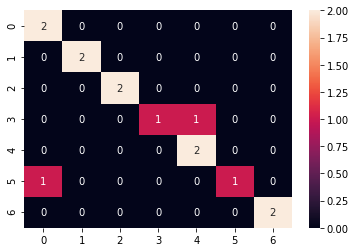

In [65]:
knn_model = KNeighborsClassifier(n_neighbors=3 ,weights='distance',)
knn_model.fit(train_vectors,train.label)
y_pred = knn_model.predict(test_vectors)
print('K = 3')
print(f'accuracy = {accuracy_score(test.label,y_pred)}')
sns.heatmap(confusion_matrix(test.label,y_pred), annot=True)
